# Imports #

In [1]:
from os import walk
from os.path import join

import pandas as pd

import matplotlib.pyplot as plt


import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

%matplotlib inline

# File paths and Constants #


In [2]:
spam_1 = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2 = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
ham_1 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
ham_2 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

##
spam_cat = 1
ham_cat = 0
vocab_size = 2500

###
Data_json = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/03_Testing/test-data.txt"

# Generator Function For Email Body Extraction #

In [3]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

            


In [4]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [5]:
spam_email = df_from_directory(spam_1, spam_cat)
spam_email= spam_email.append(df_from_directory(spam_2, spam_cat))
spam_email.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23772\2238034963.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_email= spam_email.append(df_from_directory(spam_2, spam_cat))


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [6]:
spam_email.shape

(1896, 2)

In [7]:
ham_email = df_from_directory(ham_1,ham_cat)
ham_email = ham_email.append(df_from_directory(ham_2,ham_cat))
ham_email.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23772\84638087.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_email = ham_email.append(df_from_directory(ham_2,ham_cat))


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [8]:
ham_email.shape

(3900, 2)

In [9]:
data = pd.concat([spam_email,ham_email])
data.head()
print("Shape of entire data",data.shape)

Shape of entire data (5796, 2)


In [10]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning : Checking for Missing Values

In [11]:
##Check if any message bodies are null

data["MESSAGE"].isnull().values.any() 

#["MESSAGE"] is used to extract the message colums from the dataframe. It displays few of the rows from the dataframe
# .isnull() gives us a value in terms of True or False if there is a null value or not in the dataframe.
# null value in python refers to None type Data Atrribute
#.isnull() also gives us the result in terms of few rows from the dataframe we are unable to see each and evry row and check
#if it has a null value or not
# to check taht we use .values attribute so as to get the true or false result as a numpy array 
#we then use .any() attribute to get an overall result for that array in terms of True or False to check for a null value


# an empty email just cant be a none type value it can also consist of a string with zero length

False

In [12]:
# Check for empty emails ( strings with length zero)
#we convert dataframe into string and perform a logic test

#data["MESSAGE"].str.len() == 0  using this we get many rows with False or True values with some of them skipped
#so instead we use .any attribute

(data.MESSAGE.str.len() == 0).any()
# it shows that there are messages with string with length zero but this does not give us an exact count of how many emails out of our
#dataframe contain empty emails


False

In [13]:
(data.MESSAGE.str.len() == 0).sum()
#this gives us the sum or an exact value of the emails which contain an empty body with zero string

0

In [14]:
#we can do the same for null values
(data.MESSAGE.isnull().sum())

0

# To locate empty emails

In [15]:
data[data.MESSAGE.str.len() == 0].index
#we use our dataframe along with our logic statement and use the index attribute to check for the index of the files which satisfy
#our condition
## the cmds file that we get into the list is a type of system file that we get into our systm after we unzip our data
##hence this contributes to our empty string or empty email files
##These files are in our datafram because of our generator function and specifically the walk function

Index([], dtype='object')

In [16]:
## to get the location of these files in our dataframe
#data.index.get_loc('cmds')

# Removing system files


In [17]:
#data.index.get_loc('cmds')
## as the above command is not working we will simply delete the files


# Adding Documentation Id to track Email in Dataset

In [18]:
#we will replacing the document name to document ids from 0 to 5796 for tracking purpose
document_id = range(0,len(data.index))
data["DOC_ID"] = document_id
data

,MESSAGE,CATEGORY,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,4
...,...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0,5792
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,5794


In [19]:
data['FILE_NAME'] = data.index
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,4,00005.57696a39d7d84318ce497886896bf90d


In [20]:
data.set_index('DOC_ID', inplace=True)
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Save to File using Pandas

In [21]:
data.to_json(Data_json)

# Number of Spam Messages Visualised (Pie Chart)

In [22]:
## To get a breakdown of how many messages of each category we have we will use the following
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [23]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]


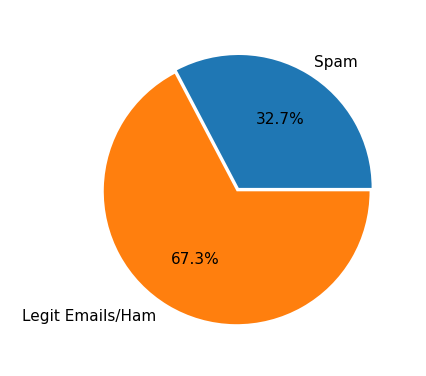

In [24]:
##Pie chart
category_names = ["Spam", "Legit Emails/Ham "]
sizes = [amount_of_spam , amount_of_ham]
plt.figure(figsize = (2,2),dpi=220)
plt.pie(sizes,labels = category_names , textprops={'fontsize': 5}, autopct = "%1.1f%%", explode=[0,0.03])
##Look for more documentation on Pie Chart
plt.show()

# Number of Spam Messages Visualised (Donut Chart)( Practice )

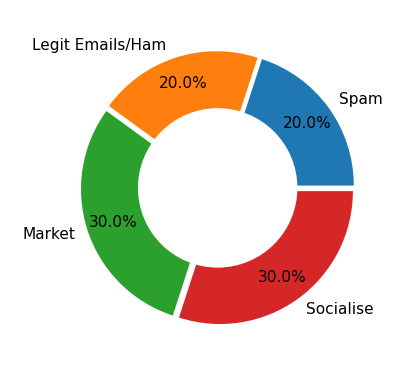

In [25]:
category_names = ["Spam", "Legit Emails/Ham ","Market", "Socialise" ]
sizes = [20,20,30,30]
plt.figure(figsize = (2,2),dpi=220)
plt.pie(sizes,labels = category_names , textprops={'fontsize': 5}, autopct = "%1.1f%%", pctdistance = 0.8,explode=[0.03,0.03,0.03,0.03])
##Look for more documentation on Donut Chart
circle = plt.Circle((0,0),radius = 0.6 , fc = "white")
plt.gca().add_artist(circle)
plt.show()

# NLP Introduction

In [26]:
## Converting email body to lower case
## Removing the stop words
## Word stemming
## Removing the punctuattion marks
## Removing HTML Tags
## Tokenising

## Text Preprocessing

In [27]:
## Converting words to lowercse in our emails
## We can do this by using the following bit of code
#msg = " All Work And No play is Boring"
#msg.lower()
# but for NlP we will be using a module  Natural Language Toolkit

### Download the NLTK Resources (Tokenizer and Stopwords )

In [28]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [30]:
# Example for Tokenising
msg = " All Work And No play is Boring"
word_tokenize(msg)

## Now to perform tokenising and turning the words into lowercase
## we can do
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'is', 'boring']

### Removing Stop Words

In [31]:
# stopwords.words("english")   ## To get a list of all the stopwords for the language english
# type(stopwords.words("english")) ## we get the type as list

## but we will be using the stopwords as a set of words , hence we need to convert it into a set 

stop_words = set(stopwords.words("english"))

if "not" in stop_words:
    print("found it")


found it


In [32]:
if "hello" not in stop_words:
    print("Not in here")

Not in here


In [33]:
# An example code which tokenises , removes stop words and converts to lowercase
msg = " All Work And No play makes Jack a dull Boy . To Be or not to BE."
msg.lower() # To convert the string into lowercase
# word_tokenize(msg.lower()) # to tokenize the lowercase string
words = word_tokenize(msg.lower()) ## to store it in a variable

filtered_words=[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### Word stems and Stemming

In [34]:
# Stemming Introduction
#stemmer might not produce proper words ..we might not end up wth a real word
## Purpose of Stemmer ?

In [35]:
# An example code which tokenises , removes stop words and converts to lowercase and stemming the words in it
msg = " All Work And No play makes Jack a dull Boy . To Be or not to BE.????##\
        TheN he goes to fishing beacause he like eating fish and crabs"
msg.lower() # To convert the string into lowercase
# word_tokenize(msg.lower()) # to tokenize the lowercase string
words = word_tokenize(msg.lower()) ## to store it in a variable

stemmer = PorterStemmer()  

filtered_words=[]
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'be.', '?', '?', '?', '?', '#', '#', 'goe', 'fish', 'beacaus', 'like', 'eat', 'fish', 'crab']


In [36]:
## PorterStemmer is specifically a stemmer for English
##There are variety of stemmer functions but the one widely used for various Languages is SnowballStemmer

### Removing Punctuations

In [37]:
#incase of a string we use the .isalpha method which checks if the given string is a character or not.
# If it is a character it gives us True and If it is a punction it gives us FALSE.
#This logic is used for removing the punctuations.

#example:
string = "I am a Hero.Are you a villain ?"
string.isalpha()
if string.isalpha() is False:
    print("There is a punctuation mark")
    
#### Example ####
# An example code which tokenises , removes stop words and converts to lowercase and stemming the words in it , and to remove the
#punctuation marks as well
msg = " All Work And No play makes Jack a dull Boy . To Be or not to BE.????##\
        TheN he goes to fishing beacause he like eating fish and crabs"
msg.lower() # To convert the string into lowercase
# word_tokenize(msg.lower()) # to tokenize the lowercase string
words = word_tokenize(msg.lower()) ## to store it in a variable

stemmer = PorterStemmer()  

filtered_words=[]
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        punc = stemmed_word.isalpha()
        if punc is False:
            filtered_words.remove(stemmed_word)
print(filtered_words)

## or ###


There is a punctuation mark
['work', 'play', 'make', 'jack', 'dull', 'boy', 'goe', 'fish', 'beacaus', 'like', 'eat', 'fish', 'crab']


In [38]:
msg = " All Work And No play makes Jack a dull Boy . To Be or not to BE.????##\
        TheN he goes to fishing beacause he like eating fish and crabs"
msg.lower() # To convert the string into lowercase
# word_tokenize(msg.lower()) # to tokenize the lowercase string
words = word_tokenize(msg.lower()) ## to store it in a variable

stemmer = PorterStemmer()  

filtered_words=[]
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        punc = stemmed_word.isalpha()
        if punc is False:
            filtered_words.remove(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'goe', 'fish', 'beacaus', 'like', 'eat', 'fish', 'crab']


### Removing HTML Tags from Emails

In [39]:
#to access a mail from our dataset we can use
data.at[2,"MESSAGE"]  #where 2 is the doc id or index and essage is the column in which our email body is.
#HTML TAGS are similar to punctuation marks , they do not provide us information when it comes to NAive BAYES 
# and bag of words approach


"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [40]:
#This is used to beautify the email body in order to see it as in a text editor like atom
#soup =  BeautifulSoup(data.at[2,"MESSAGE"],"html.parser")  ##html parser is a built in parser ..what is a parser?
#print(soup.prettify())


In [41]:
#soup.get_text()  ### This removes all the HTML tag from the email body. 
## we can verify by looking into the mail body and see that there are no <b> tags

## Function for Email Processing

In [42]:
def clean_message(message, stemmer = PorterStemmer(), 
stop_words = set(stopwords.words("english"))):
    
    #To remove HTML Tags
    soup =  BeautifulSoup(message,"html.parser")
    clean_text = soup.get_text()  
    
    ##for tokenising and converting to lowercase
    words = word_tokenize(clean_text.lower())
    filtered_words = []
    
    #for stemming and removing the punctuations
    for word in words:
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
            punc = stemmed_word.isalpha()
            if punc is False:
                filtered_words.remove(stemmed_word)     
    return filtered_words

In [43]:
clean_message(data.at[2,"MESSAGE"])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all E-mails

### Slicing dataframes and series and Creating Subsets

In [44]:
data.iat[3,0] ## can accerss data by location here 2 is the position or index and 2 is the 2nd column

"##################################################\n\n#                                                #\n\n#                 Adult Club                     #\n\n#           Offers FREE Membership               #\n\n#                                                #\n\n##################################################\n\n\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n\n>>>>>  Your User Name And Password is.\n\n>>>>>  User Name: zzzz@spamassassin.taint.org\n\n>>>>>  Password: 760382\n\n\n\n5 of the Best Adult Sites on the Internet for FREE!\n\n---------------------------------------\n\nNEWS 08/18/02\n\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n\nMembers. Are you one of them yet???\n\n---------------------------------------\n\nOur Membership FAQ\n\n\n\nQ. Why are you offering free access to 5 adult membership sites for free?\n\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\n\n\nQ. Is it true m

In [45]:
data.iloc[0:5] ## used to get a subset of data from a dataframe
## it works on series as well as dataframe
data.MESSAGE.iloc[5:7] ## works well on series as well as data frames , gives a subset with a specifes range of indices

DOC_ID
5    A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6    Help wanted.  We are a 14 year old fortune 500...
Name: MESSAGE, dtype: object

In [46]:
datalist = data.MESSAGE.iloc[5:7] ### this will give us a series and stored in a variable
nested_list = datalist.apply(clean_message) 
##this will give us a series as well in the form of a list , the list will contain all the texts when the function of clean_message
## is apllied on it

nested_list


DOC_ID
5    [powerhous, gift, program, want, miss, get, fo...
6    [help, want, year, old, fortun, compani, grow,...
Name: MESSAGE, dtype: object

In [47]:
## we will perform the same for the subset and instead of getting a series of list we will try to get a single list of words 
##containing all the pre-procesed words of the subset of emails in a single list
## using for loops
flat_list =[] ## empty list which will contain all the  pre-processed words from the subset of emails
for sublist in nested_list :
    for items in sublist:
        flat_list.append(items)
        
print(len(flat_list))
#print(flat_list)


208


In [48]:
## using list comprehension
flat_list = [items for sublist in nested_list for items in sublist]
print(len(flat_list))
#print(flat_list)

208


In [49]:
#%%time ## time gives us an idea about the computational time taken for a code to run
## to use apply() function on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message) 
## the warning for BEAUTIFULSOUP can be ignored


C:\Users\LENOVO\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [50]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [51]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

#### Creating a subset of a dataframe based on a condition (logic)

In [52]:
##challenge : Creat two variables (doc_id_spam) and (doc_id_ham) which
## hold on to the indices wfor the spam and non spam emails respectively

In [53]:
doc_id_spam = data[data.CATEGORY == 1].index ## the condition mentioned here is include only those messages with 1 category
## only if this condition is true we will be getting a subset
doc_id_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

In [54]:
doc_id_ham = data[data.CATEGORY == 0].index
doc_id_ham
##.index will give us the indices of those messages which satisfy the condition

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [55]:
## creating two different subset containing email bodies of spam and ham emails seperatly
# nested_list = data.MESSAGE.apply(clean_message) 
nested_list_spam = nested_list.loc[doc_id_spam]
##  nestedlist variable contains our apply () function
## .loc method will require a range of indices
## doc_id_spam contains a list of all the indices

## hence we get a series of lists with all the preprocessed words from each spam email.

nested_list_spam
#type(nested_list_spam)



DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [56]:
## for ham emails
nested_list_ham = nested_list.loc[doc_id_ham]
nested_list_ham

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [57]:
## Challenge
## for Spam emails
flat_list_spam=[items for subitems in nested_list_spam for items in subitems]
len(flat_list_spam)
type(flat_list_spam)

list

In [58]:
## to print out the top 10 most commonly used words in the list flat_list_spam
spammy_words = pd.Series(flat_list_spam).value_counts()

## pd.Series creates a series from a list

## value_counts Return a Series containing counts of unique values.
## The resulting object will be in descending order so that the first element is the most frequently-occurring element. 
#Excludes NA values by default.

spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [59]:
spammy_words.shape

(13241,)

In [60]:
## Challenge
## for Spam emails
flat_list_ham=[items for subitems in nested_list_ham for items in subitems]
len(flat_list_ham)

442046

In [61]:
## to print out the top 10 most commonly used words in the list flat_list_ham
ham_words = pd.Series(flat_list_ham).value_counts()

## pd.Series creates a series from a list

## value_counts Return a Series containing counts of unique values.
## The resulting object will be in descending order so that the first element is the most frequently-occurring element. 
#Excludes NA values by default.

#ham_words.shape

ham_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

 ## Genarating Vocabulary and Dictionary

In [62]:
## We wont be using all the words that apppear in the email body , but we weil be using 
#the most frequent words that appear int hese emails
# We will be using 2500 most frequent words
nested_list = data.MESSAGE.apply(clean_message) 
flat_list = [items for sublist in nested_list for items in sublist]
##This includes a list of all words in all our emails inlcding spam and ham both
# len(flat_list)

# to convert this list into a panda series
# reason to apply the value_count method to check for unique frequent words
unique_words = pd.Series(flat_list).value_counts()


C:\Users\LENOVO\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [63]:
frequent_words = unique_words[0:vocab_size] # #vocab_size defined in constants

In [64]:
frequent_words[:10] ## for printing top 10 frequent words

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

In [65]:
type(frequent_words)

pandas.core.series.Series

 ## Create Vocabulary Dataframe with a Word Id and saving it as a CSV file

In [66]:
word_ids = range(0,vocab_size)
vocab = pd.DataFrame({"VOCAB_WORD":frequent_words.index.values},index = word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


 ## Save the Vocabulary as a CSV File

In [67]:
vocab.to_csv(WORD_ID_FILE,index_label =vocab.index.name ,header = vocab.VOCAB_WORD.name)

 ## Exercise :Check whether a code is in the vocabulary list

In [68]:
## Challenge write a code to check if the following words are in the vocabulary or not.
## Return true if it is , if not false
## check words : machine , learning , fun, data , science,app , brewery

##code :


## EXERCISE : Find the email with the most number of words

In [69]:
## Challenge : Print out the number of words in the longest email (after cleaning and stemming)
## Note the longest email's position in the list of cleaned emails. Print out the stemmed list of words
## in the longest email . Print out the longest email from the dataframe

# Generate Features and Sparse Matrix

### Creating a Dataframe with One Word Column

In [70]:
nested_list ## This is a  series having lists for each mail which contains stemmed word from the email bodies
## this list will contain all the 5786 mails and all the lists in this series contains stemmed word for each of the email body

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [71]:
type(nested_list) ## the nested list is a series having lists

#to convert this series having lists into a dataframe we will convert this into a list having lists

pandas.core.series.Series

In [72]:
# We convert a series into a list we use
updated_nested_list = nested_list.tolist()
# This gives a list containing list of all the stemmed word for each mail

In [73]:
# we convert this list of all list to a dataframe by using the ,from_records for the pd.DataFrame
# and store it in a variable
words_column_df = pd.DataFrame.from_records(updated_nested_list)


In [74]:
words_column_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [75]:
words_column_df.shape

#5796 rows represent the total number of emails the we have supplied to the dataframe (both spam and ham)
# The number 7671 represents the length of the longest email..i.e the largest number of words an email has
# although the last columns may show a none value, there might be some mail in between the range of 5796 mails which may have the
# end rows having some word


(5796, 7671)

# Splitting the data into Training set and Test set

In [76]:
## import train_test_split from sklearn

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(words_column_df, data.CATEGORY, test_size = 0.3 , random_state = 42)

In [78]:
# to analyse the test train split
print("the number of samples in the train set is ", X_train.shape[0])
print("The fraction of training set is " , X_train.shape[0] / words_column_df.shape[0] )

the number of samples in the train set is  4057
The fraction of training set is  0.6999654934437544


In [79]:
X_train.index.name = "DOC_ID"
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [96]:
X_train.shape

(4057, 7671)

In [95]:
Y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [97]:
Y_train.shape

(4057,)

In [99]:
Y_test.shape

(1739,)

### Creating a sparse matrix for the Training Data

In [80]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [100]:
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'fashion', 'invalid', 'raid', 'distributor', 'tobacco', 'till', 'corn',
       'analog', 'apach', 'overnight'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [81]:
word_index.get_loc("thu")

393

In [82]:
#### Sparse matrix function

def make_sparse_matrix(df, indexed_words , labels):
    """"
    Returns sparse matrix as a dataframe
    df: A dataframe with words in the colums with a document ID as index (X_train or X_test)
    indexed_words :  index of words ordered by word id
    labels : category as (y_train or y_test)
    
    """
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            word = df.iat[i,j]     ### iat gives the word using the indices in the dataframe
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word) ##get_loc gives us the index of the word given in the parenthesis
                category = labels.at[doc_id]
                
                item = {"LABEL" : category , "DOC_ID" : doc_id , "WORD_ID" : word_id , "OCCURENCE": 1}
                
                dict_list.append(item)
                
            
    return pd.DataFrame(dict_list)
    

In [83]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, Y_train)

CPU times: total: 16min 45s
Wall time: 18min 27s


In [84]:
sparse_train_df.shape

(429184, 4)

In [101]:
sparse_train_df.tail()

,LABEL,DOC_ID,WORD_ID,OCCURENCE
429179,1,860,47,1
429180,1,860,1431,1
429181,1,860,26,1
429182,1,860,21,1
429183,1,860,126,1


### Combine occurrences with pandas groupby( ) method

In [85]:
train_grouped = sparse_train_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum()
train_grouped.head()


OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [86]:
## to keep the DOC_ID for every entry
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [87]:
train_grouped.shape

(258332, 4)

### Saving Training Data as .txt file

In [88]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt="%d")

 ### Creating a Sparse matrix for Test Data

In [89]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, Y_test)

CPU times: total: 7min 41s
Wall time: 8min 4s


In [90]:
sparse_test_df.shape

(203404, 4)

### Combine occurrences with pandas groupby( ) method

In [91]:
test_grouped = sparse_test_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum()
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [92]:
test_grouped.shape

(117774, 4)

### Saving Test Data as .txt file

In [93]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")